In [1]:
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


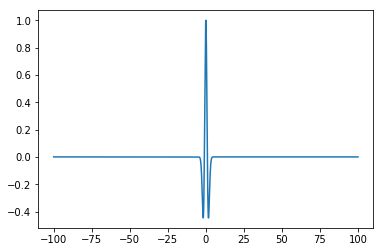

(3600,)


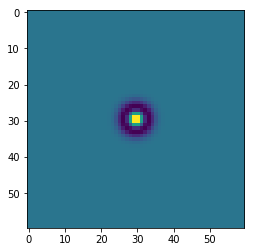

0.0643733223487


In [349]:
def W_zero1d(x):
    a          = 1.0
    lambda_net = 4.0
    beta       = 3.0 / lambda_net**2
    gamma      = 1.05 * beta
    
    x_length_squared = x**2
    
    return a*np.exp(-gamma*x_length_squared) - np.exp(-beta*x_length_squared)

def W_zero2d(x, mu):
    """
    @param x (numpy array)
    A point
    """
    a          = 1.0
    lambda_net = 10.0
    beta       = 3.0 / lambda_net**2
    gamma      = 1.05 * beta
    
    x_length_squared = np.sum( (x - mu)**2, axis=1)
    
    return a*np.exp(-gamma*x_length_squared) - np.exp(-beta*x_length_squared)



def mexican_hat1d(x, sigma=1.):
    a = 2./ ( np.sqrt(3*sigma) * np.power(np.pi,0.25 ) )
    b = (1. - (x/sigma)**2 )
    c = np.exp( - x**2/(2*sigma**2))

    return b*c
    
def mexican_hat2d(x, mu=np.array([0.,0.]) ,sigma=1.):
    mu = mu.reshape((1,2))
    norm_sq = np.sum((x - mu)**2, axis=1)
    
    a = 1./(np.pi*sigma**2)
    b = 1. - (norm_sq/sigma**2)/.9
    c = np.exp( - norm_sq/(2.*sigma**2))

    return a*b*c
    
x = np.linspace(-100.,100.,num=10000)
y = mexican_hat1d(x)

plt.plot(x,y)
plt.show()               

r = 60

X = np.indices((r,r)).reshape((2,-1)).T.astype(float)   

Y = mexican_hat2d(X, mu=np.array([0.5*(r-1),0.5*(r-1)]), sigma=2. )
# Y = W_zero2d(X, mu=np.array([0.5*(r-1),0.5*(r-1)]) )
print Y.shape
plt.imshow(Y.reshape((r,r)))
plt.show()
print np.amax(Y)


0.606530659713 0.8


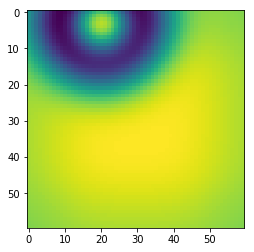

In [370]:
def normalize(x):
    x_   = x - np.amin(x)
    amax = np.amax(x_)

    if amax != 0.:
        x_ = x_/amax
    
    return x_

def create_WXE(r, s, l=0.5):
    num_units = r*r
    X = np.indices((r,r)).reshape((2,-1)).astype(float)*s/r

    e = np.random.randn(num_units,2)
    e = e/np.sqrt(np.sum(e**2, axis=1, keepdims=True))
    W = np.zeros((num_units, num_units))
        
    for i in range(num_units):
        for j in range(num_units):
            W[i,j] =  w_0(X[:,i] - X[:,j] - l*e[j])
    
    return W,X.T,e

# def create_W(r,w, sigma=1.):
#     n = r**2
#     X = np.indices((r,r)).reshape((2,-1)).T.astype(float)*w/r
#     W = np.zeros((n, n))
#     for i in range(n):
#         for j in range(n):
#             W[i,j] =  np.exp(- np.sum( (X[i] - X[j])**2)/sigma)  
            
#     W = W - 0.1


#     return W

def create_mexican_W(r,w, sigma=1.):
    n = r**2
    X = np.indices((r,r)).reshape((2,-1)).T.astype(float)/r
    W = np.zeros((n, n))
    for i in range(n):
#         X_ = X - X[i].reshape((1,2))
#         mask = np.sum(X_**2, axis=1) < 0.09
        d = np.sum((X[i] - 0.5 )**2)
        c = np.exp(-d/1.)
        c = np.minimum(c, 0.8)
        W[i] = c*mexican_hat2d(X, mu=np.array(X[i]), sigma=sigma)
#         W[i] /= np.abs(np.sum(-W[i]))
#         W[i] *= mask
    
    return W 

def create_W(r,w, row_fct):
    n = r**2
    X = np.indices((r,r)).reshape((2,-1)).T.astype(float)*10/r*w
    W = np.zeros((n, n))
    for i in range(n):
            W[i] =  row_fct(X, X[i])
            
    for i in range(n):
            W[:,i] -= np.mean(W[:,i])

    return W 



r = 60
w = 3.
n = r*r

X = np.indices((r,r)).reshape((2,-1)).T.astype(float)/r
d = np.sum((X - 0.5 )**2, axis=1)
c = np.exp(-d/1.)
c = np.minimum(c, 0.8)
print np.amin(c), np.amax(c)

# plt.imshow(c.reshape((r,r)))
# plt.show()
# W = create_mexican_W(r, w, .07)


W = create_W(r, w, W_zero2d)
# W = create_W(r, w, mexican_hat2d)

# plt.imshow(W[14].reshape((r,r)) < 0)
plt.imshow(W[3*r + r//3].reshape((r,r)))
# plt.imshow(W)





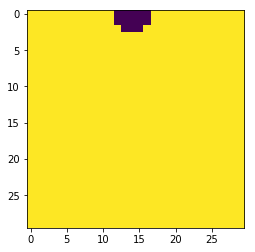

In [4]:
plt.imshow(W[14].reshape((r,r)) < 0)
# plt.imshow(W[3*r + r//3].reshape((r,r)))
# plt.imshow(W)


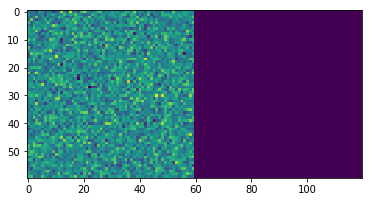

0.015025573127 0.0167479622448


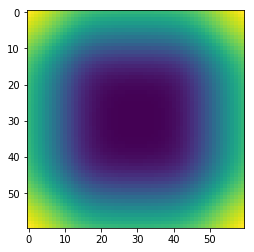

In [371]:

def evolve(s, W, b, time=500):

    dt   = 0.001
    tau  = 1.0
    S    = np.zeros((time, W.shape[1]))
    S[0] = s[:] 
    for t in range(1, time):
#         noise = np.random.randn(n)*0.005
        noise = 0.
        ds  = dt*( np.maximum(  np.dot(W, S[t-1] + noise) + b, 0.) - S[t-1])
        S[t,:]  = S[t-1,:] + tau*ds
        S[t,:] /= np.sum(S[t,:]**2)

        
    return S
        
x = np.array([
    [0.5*w],
    [0.5*w]
]) 



# B = np.exp( - np.sum( 0.06*(X - x.T)**2, axis= 1) )

# b = np.random.randn(n)
# b = np.zeros(n)
b = 2.*np.ones(n)
# b[310] = .4
# s = S[-1] 
# s = np.zeros(n)
s =  np.random.randn(n)
# s = np.random.sample(n)


T = 500

imgs  = [s.reshape((r,r)), b.reshape((r,r))]
imgs_ = [normalize(x) for x in imgs]


S = evolve(s, W, b, time=T)



img = np.concatenate( imgs_, axis=1)
plt.imshow(img)
plt.show()





# plt.figure(figsize=(20,10))
# plt.imshow(S[-100:].T)
# plt.show()

img = S[-1].reshape((r,r))
print np.amin(img), np.amax(img)
# plt.imshow(img, vmax=0.003)
plt.imshow(img)
plt.show()


0.00030334194743 0.000432311587599


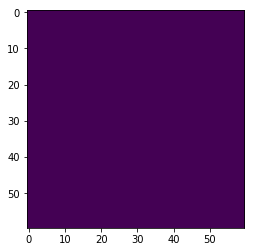

In [347]:
img = S[-1].reshape((r,r))
print np.amin(img), np.amax(img)
plt.imshow(img > 0.003)
plt.show()

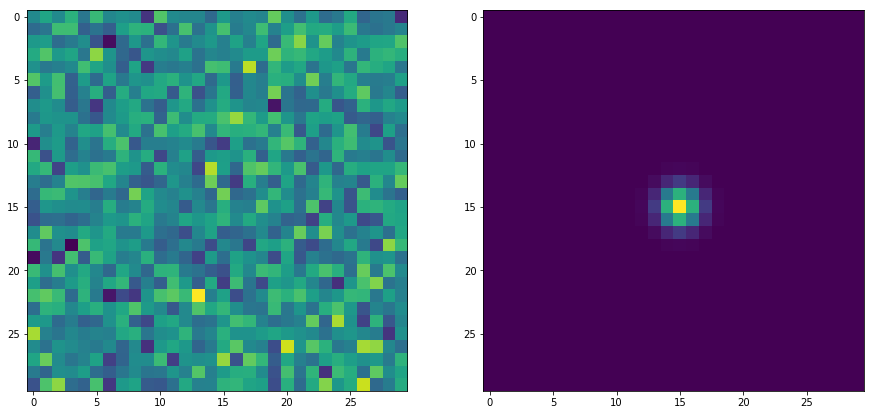

In [217]:
from matplotlib import animation, rc
from IPython.display import HTML


fig, ax = plt.subplots(1, 2, figsize=(15, 10));



# animation function. This is called sequentially
def animate(i):
    ax[0].imshow(S[i].reshape((r,r)), animated=True)
    ax[1].imshow(B.reshape((r,r)), animated=True)
    return []


# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=T, interval=100, blit=True)

HTML(anim.to_html5_video())

# Recurrent connections

In [19]:
dimensions = (32, 32)
can = ContinuousAttractorModule(dimensions)

Here are the outputs of each cell. Hover over a cell to see its inhibitory output. Red means strong inhibition.

In [6]:
printOutputWeights(json.dumps({
    "dimensions": dimensions,
    "inputMatrices": dict((k, weights.tolist())
                          for k, weights in can.recurrentWeights.iteritems())
}))

NameError: name 'printOutputWeights' is not defined

Here are the inputs to each cell. Hover over a cell to see its inhibitory input.

In [ ]:
printInputWeights(json.dumps({
    "dimensions": dimensions,
    "inputMatrices": dict((k, weights.tolist())
                          for k, weights in can.recurrentWeights.iteritems())
}))

# Lattice orientation

In [21]:
def orientationExperiment():
    dimensions = (32,32)
    recording = {
        "dimensions": dimensions,
        "timesteps": [],
    }

    can = ContinuousAttractorModule(dimensions)

    for k, rates in can.firingRates.iteritems():
        rates[:] = np.random.rand(dimensions[0]*dimensions[1])

    for t in xrange(500):
        if t % 10 == 0:
            recording["timesteps"].append(
                dict((k, rates.tolist())
                     for k, rates in can.firingRates.iteritems()))

        can.step(np.array([0.0, 0.0]))

    recording["timesteps"].append(
        dict((k, rates.tolist())
             for k, rates in can.firingRates.iteritems()))
    
    return recording

Sometimes the lattice is aligned with the x axis.

In [22]:
recording1 = orientationExperiment()

In [23]:
printSpikeRatesTimeline(json.dumps(recording1))

NameError: name 'printSpikeRatesTimeline' is not defined

And sometimes it's aligned with the y axis.

In [ ]:
recording2 = orientationExperiment()

In [ ]:
printSpikeRatesTimeline(json.dumps(recording2))

In [ ]:
def orientationExperiment2():
    dimensions = (16,16)
    recording = {
        "dimensions": dimensions,
        "timesteps": [],
    }

    can = ContinuousAttractorModule(dimensions)

    for k, rates in can.firingRates.iteritems():
        rates[:] = np.random.rand(dimensions[0]*dimensions[1])
        
    for t in xrange(500):

        can.step(np.array([0.0, 0.0]))


    for t in xrange(1500):
        if t % 100 == 0:
            recording["timesteps"].append(
                dict((k, rates.tolist())
                     for k, rates in can.firingRates.iteritems()))

        can.step(np.array([1.5, 0.0]))

    recording["timesteps"].append(
        dict((k, rates.tolist())
             for k, rates in can.firingRates.iteritems()))
    
    return recording

In [ ]:
recording3 = orientationExperiment2()

In [ ]:
printSpikeRatesTimeline(json.dumps(recording3))